In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from photutils.segmentation import SourceCatalog
from photutils import SegmentationImage
import quicklook as jql
import jades_photutils_interface as jpui
import time
import os
import sep
from comet_ml import Experiment
import torch
from torchvision import models
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import CenterCrop
from reproject.mosaicking import find_optimal_celestial_wcs
from dataset import SR_HST_HSC_Dataset
import generator
import torchvision.transforms.functional as TF
from typing import Tuple
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.nddata.utils import NoOverlapError
from tqdm import tqdm
from morpheus_core import morpheus_core


### Load HSC/HST 

In [2]:
hdul_hsc = fits.open("../../../data/cutout-HSC-I-9813-pdr2_dud-210317-161628.fits")

In [5]:
hdul_hsc[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT DAS Cutout version 200424                                               
HIERARCH variance_scale = 1.38247518094125                                      
BGMEAN  =  0.00533468603441475                                                  
BGVAR   = 4.80108550067994E-05                                                  
AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to 
HIERARCH COADD_INPUTS_ID = 1 / archive ID for coadd inputs catalogs             
HIERARCH AP_CORR_MAP_ID = 72

In [3]:
hdul_hsc

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fe576050f40>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe55ffc8fa0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe55ffc82e0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe55ffc8ee0>]

In [6]:
hdul_hst = fits.open("../../../data/hlsp_candels_hst_acs_cos-tot_f814w_v1.0_drz.fits")
# hdul_hst_wht = fits.open("../../../data/hlsp_candels_hst_acs_cos-tot_f814w_v1.0_wht.fits")

In [9]:
hdul_hst[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                28000                                                  
NAXIS2  =                72000                                                  
FILENAME= 'hlsp_candels_hst_hst_candels-v1.0_acs_f814w_drz.fits' / MAST HLSP Fil
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =          150.1163213                                                  
CRVAL2  =         +2.200973097                                                  
CRPIX1  =              14800

In [5]:
img = fits.getdata("morpheus-tests/output.fits")
n = fits.getdata("morpheus-tests/n.fits")

In [6]:
y,x = np.where(n>1)
means = img[y,x,0,0]
var = img[y,x,0,1]
draw = np.random.normal(means,np.sqrt(var))

mean_cop = img[:,:,0,0].copy()

mean_cop[y,x] = draw

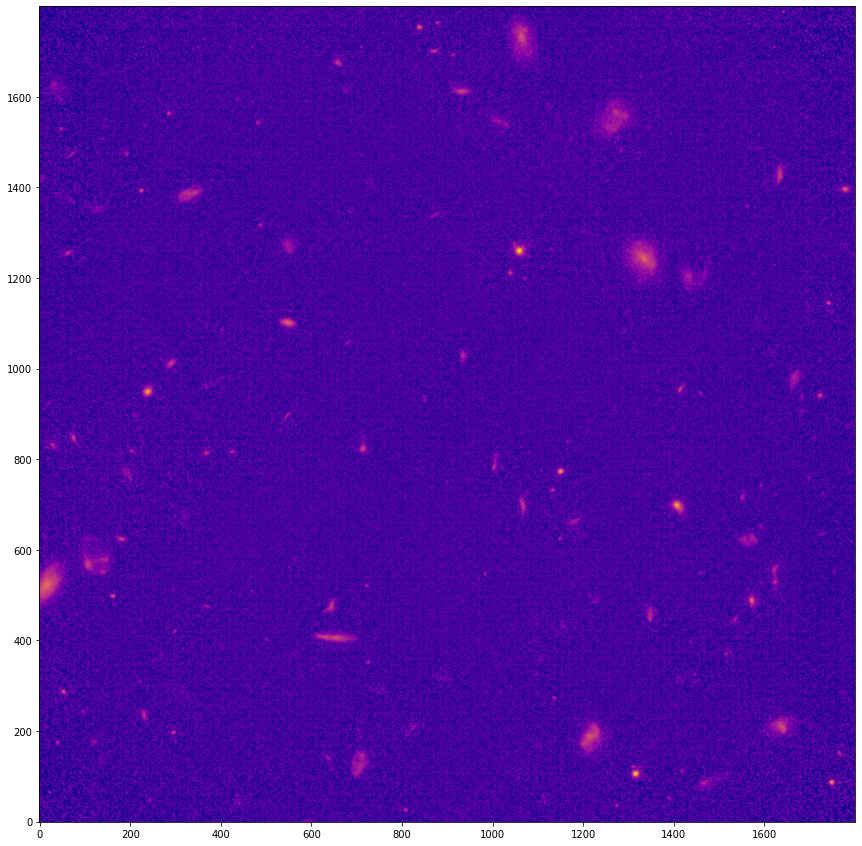

In [7]:
f, axarr = plt.subplots(1,1,figsize=(15,15))
clipped_img = np.clip(img[...,0],0,1)
clipped_mean_var = np.clip(mean_cop,0,1)
axarr.imshow(clipped_mean_var, 
               cmap="plasma", 
               origin="lower",
               norm=simple_norm(clipped_mean_var, stretch="log"))
# plt.colorbar()

In [8]:
hdul_hst_wht[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                28000                                                  
NAXIS2  =                72000                                                  
FILENAME= 'hlsp_candels_hst_hst_candels-v1.0_acs_f814w_wht.fits' / MAST HLSP Fil
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =          150.1163213                                                  
CRVAL2  =         +2.200973097                                                  
CRPIX1  =              14800

In [9]:
hdul_hst[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                28000                                                  
NAXIS2  =                72000                                                  
FILENAME= 'hlsp_candels_hst_hst_candels-v1.0_acs_f814w_drz.fits' / MAST HLSP Fil
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =          150.1163213                                                  
CRVAL2  =         +2.200973097                                                  
CRPIX1  =              14800

In [13]:
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils import SegmentationImage
from photutils.segmentation import detect_sources

npos=100
#get shape of image
shape = hdul_hst[0].data.shape
shape = mean_cop.shape
# mask = SegmentationImage(mean_cop) #hst segmap
# data_hst, segm_hst_data, cdata_hst = jpui.ReadSourceCatalogImages(fname_hst)

mask = detect_sources(mean_cop,.5,5).data #hst segmap
mask[mask>0] = 1

# #get random positions
positions = np.zeros((npos,2))
positions[:,0] = np.random.uniform(high=shape[0],size=npos)
positions[:,1] = np.random.uniform(high=shape[1],size=npos)
#linear pixels
N_nmad_max = 35.0 #pixels >~1 arcsec max
n_nmad = 40
N_nmad_table = np.linspace(1.,N_nmad_max,n_nmad)
#radii
A_nmad = N_nmad_table**2 #area in pixels**2
r_nmad = (A_nmad / (np.pi))**0.5 #aperture radii in pixels
#get apertures
apertures = [CircularAperture(positions,r=r) for r in r_nmad]
#what is the pixel variance?
print(f"Pixel stddev = {np.nanstd(hdul_hst[0].data*1)}")
#perform photometry
#phot_table = aperture_photometry(data_nmad * f_data_to_e, apertures, mask=mask)
phot_table = aperture_photometry(mean_cop, apertures,mask=mask)
# texp_table = aperture_photometry(data_texp, apertures)
#record the sigmas and exposure times
sigma_nmad_table = np.zeros(n_nmad)
texp_nmad_table = np.zeros(n_nmad)
#compute the std of the aperture fluxes x t_exposure
for i in range(n_nmad):
    print(i)
    x = phot_table[f'aperture_sum_{i}']           #aperture flux
    t =6900# texp_table[f'aperture_sum_{i}']/A_nmad[i] #average exposure time
    sigma_nmad_table[i] = np.nanstd(x*t)          #RMS # of electrons
    texp_nmad_table[i]  = np.nanmean(t)           #mean of exposure times
# #test
np.savetxt("sample"+'.nmad', np.c_[N_nmad_table,sigma_nmad_table,texp_nmad_table])
#fit a power law
p = np.polyfit(np.log10(N_nmad_table),np.log10(sigma_nmad_table),1)
print(f"NMAD fit normalization = {p[1]}, power law index = {p[0]}.")

KeyboardInterrupt: 

/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Mosaic')

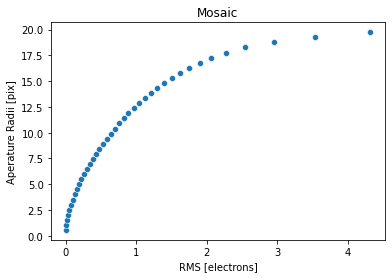

In [79]:
import seaborn as sns
sns.scatterplot(sigma_nmad_table,r_nmad)
plt.xlabel("RMS [electrons]")
plt.ylabel("Aperature Radii [pix]")
plt.title("Mosaic")

In [30]:
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils import SegmentationImage
from photutils.segmentation import detect_sources
def rms_aperature_comp(data):
    
    npos=100
    #get shape of image
    shape = data.shape

    mask = detect_sources(data,.5,5).data #hst segmap
    mask[mask>0] = 1

    #get random positions
    positions = np.zeros((npos,2))
    positions[:,0] = np.random.uniform(high=shape[0],size=npos)
    positions[:,1] = np.random.uniform(high=shape[1],size=npos)
    
    
    #linear pixels
    N_nmad_max = 35.0 #pixels >~1 arcsec max
    n_nmad = 40
    N_nmad_table = np.linspace(1.,N_nmad_max,n_nmad)
    
    #radii
    A_nmad = N_nmad_table**2 #area in pixels**2
    r_nmad = (A_nmad / (np.pi))**0.5 #aperture radii in pixels
    
    #get apertures
    apertures = [CircularAperture(positions,r=r) for r in r_nmad]
    
    #what is the pixel variance?
    print(f"Pixel stddev = {np.nanstd(data*1)}")
    
    #perform photometry
    #phot_table = aperture_photometry(data_nmad * f_data_to_e, apertures, mask=mask)
    phot_table = aperture_photometry(data, apertures,mask=mask)
    # texp_table = aperture_photometry(data_texp, apertures)
#     print(phot_table)
    #record the sigmas and exposure times
    sigma_nmad_table = np.zeros(n_nmad)
    texp_nmad_table = np.zeros(n_nmad)
    t = 1 
    #compute the std of the aperture fluxes x t_exposure
    for i in range(n_nmad):
        x = phot_table[f'aperture_sum_{i}']           #aperture flux
        sigma_nmad_table[i] = np.nanstd(x*t)          #RMS # of electrons
        texp_nmad_table[i]  = np.nanmean(t)           #mean of exposure times
        
    # #test
    np.savetxt("sample"+'.nmad', np.c_[N_nmad_table,sigma_nmad_table,texp_nmad_table])
    
    #fit a power law
    p = np.polyfit(np.log10(N_nmad_table),np.log10(sigma_nmad_table),1)
    print(f"NMAD fit normalization = {p[1]}, power law index = {p[0]}.")
    return sigma_nmad_table,r_nmad


sigma_nmad_table_hst,r_nmad_hst = rms_aperature_comp(hdul_hst[0].data[20000:21800,20000:21800])
sigma_nmad_table_sr,r_nmad_sr = rms_aperature_comp(mean_cop)

Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.851398143052662, power law index = 1.9563429303783955.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -3.012712410282217, power law index = 2.1780256634800863.


In [31]:
hst_rms = list(map(lambda _:rms_aperature_comp(hdul_hst[0].data[20000:21800,20000:21800])[0],range(10)))

Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.7395176268389587, power law index = 1.7099560110649366.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.5885691711878303, power law index = 1.6892392284706177.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.6225975317012686, power law index = 1.9347457095346858.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.0434776607083722, power law index = 1.8064727266074507.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.347085340217971, power law index = 1.583050827142388.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.622033917696972, power law index = 1.932596217430704.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.673385786823597, power law index = 1.7739479101808318.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.8145450751089935, power law index = 1.86573338830339.
Pixel stddev = 0.1393275409936905
NMAD fit normalization = -2.7

/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HST')

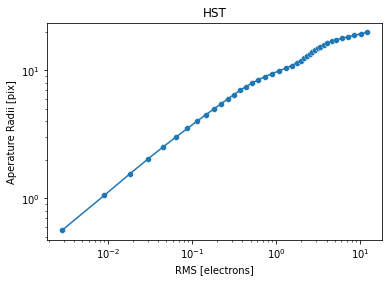

In [23]:
import seaborn as sns
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
sns.scatterplot(np.mean(np.array(hst_rms),axis=0),r_nmad_hst)

sns.lineplot(np.mean(np.array(hst_rms),axis=0),r_nmad_hst)
plt.xlabel("RMS [electrons]")
plt.ylabel("Aperature Radii [pix]")
plt.xscale('log')
plt.yscale('log')
plt.title("HST")

In [25]:
img

array([[[[8.26905074e-04, 0.00000000e+00]],

        [[1.10749609e-03, 0.00000000e+00]],

        [[1.03064638e-03, 0.00000000e+00]],

        ...,

        [[2.06232080e-08, 0.00000000e+00]],

        [[2.00912964e-05, 0.00000000e+00]],

        [[1.07288365e-08, 0.00000000e+00]]],


       [[[2.03818129e-03, 0.00000000e+00]],

        [[2.81284750e-03, 0.00000000e+00]],

        [[1.25497114e-04, 0.00000000e+00]],

        ...,

        [[4.13060206e-07, 0.00000000e+00]],

        [[1.41319376e-03, 0.00000000e+00]],

        [[7.19531206e-04, 0.00000000e+00]]],


       [[[1.51685195e-03, 0.00000000e+00]],

        [[1.67619425e-03, 0.00000000e+00]],

        [[7.14186346e-04, 0.00000000e+00]],

        ...,

        [[1.87694991e-03, 0.00000000e+00]],

        [[3.91120184e-03, 0.00000000e+00]],

        [[1.42185460e-03, 0.00000000e+00]]],


       ...,


       [[[1.38193823e-03, 0.00000000e+00]],

        [[2.25991197e-03, 0.00000000e+00]],

        [[8.71939585e-04, 0.00000000e+

In [27]:
sr_rms = list(map(lambda _:rms_aperature_comp(mean_cop)[0],range(10)))

Pixel stddev = 0.09143368154764175
NMAD fit normalization = -2.6113876711447443, power law index = 1.597472121505687.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -1.170571711997729, power law index = 1.3720482781958614.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -2.9442965972778463, power law index = 1.8651625222662425.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -3.6290117952356344, power law index = 2.5502368419668273.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -3.158669093988319, power law index = 1.5336488264639803.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -3.0720681733044617, power law index = 1.9569013592205904.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -3.393008320754707, power law index = 1.8664223731073606.
Pixel stddev = 0.09143368154764175
NMAD fit normalization = -2.5111186924046027, power law index = 1.4086686200833507.
Pixel stddev = 0.09143368154764175
NMAD fit normaliz

/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/samuelkahn/Desktop/Astro - Deep Learning/Brants Group/hsc_hst_data/src/training-srresnet/srgan-hubble/lib/python3.9/site-packages/seaborn/_decorators.py:

Text(0.5, 1.0, 'SR')

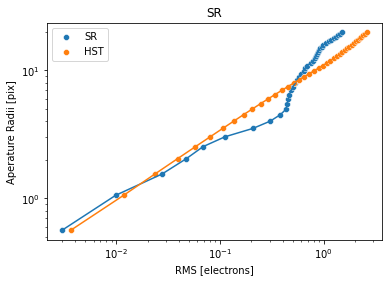

In [32]:
sns.scatterplot(np.mean(np.array(sr_rms),axis=0),r_nmad_hst,label="SR")
sns.lineplot(np.mean(np.array(sr_rms),axis=0),r_nmad_sr)
sns.scatterplot(np.mean(np.array(hst_rms),axis=0),r_nmad_hst,label="HST")

sns.lineplot(np.mean(np.array(hst_rms),axis=0),r_nmad_hst)
plt.xlabel("RMS [electrons]")
plt.ylabel("Aperature Radii [pix]")
plt.xscale('log')
plt.yscale('log')
plt.title("SR")

# TODO